In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
import pyro
from IPython.display import HTML

pio.renderers.default = "notebook"


import collab2.foraging.toolkit as ft
from collab2.foraging import random_hungry_followers as rhf
from collab2.utils import find_repo_root

root = find_repo_root()
logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, 
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

notebook_starts = time.time()

# Random Foragers

Users of the foraging toolkit are interested in analyzing animal movement data, with the goal of determining what factors contribute to each agent's decisions of where to move. 

This notebook uses the foraging toolkit to simulate movements of random foraging agents.

In this demo on simulated data, we consider agents who move in random directions with random step sizes (with some step distance preferences).

At the next stage, we would like to infer which factors influence the agents' movement.
We consider two possible factors: proximity to other agents, and closeness to food. Each factor has an associated score that is computed at each location where an agent might move. These scores are used as derived predictors in a statistical model of agents' movements. 

The fit coefficients of these derived predictor scores can be interpreted as how predictive each factor is of agents' movement decisions.

For the random agents, we expect that neither promixity nor food have any significant effect.

## Simulation

The `random-hungry-followers` module, imported as `rhf`, lets us simulate different groups of agents foraging in a gridworld environment. The user can adjust how big the environment is, how many agents are in the group, how much food reward is present, etc. The `probabilities` argument controls the (unnormalized) probability of choosing a step of each size in `[-max_step_size, max_step_size]`. For further explanation of what each input parameter means, run `help(rhf.RandomForagers)`.

Currently the step sizes are pre-defined to the range $[-4,\dots,4]$.

**Simulation of Random Foragers**

- **Initialization**
    - Initialize the grid with a specified grid size.
    - Randomly place `num_rewards` rewards on the grid.
    - Normalize the probabilities for forager step size.

- **Generate Random Paths**
    - For each forager:
        - Generate random `x` and `y` coordinates as the cumulative sum of centered random steps based on the initialized probabilities, for example:
            ```python
            forager_x = np.cumsum(np.random.choice(num_steps, num_frames, probabilities, replace=True)) + (grid_size / 2)
            forager_y = ...  # same as for x
            ```
        - Ensure the coordinates stay within the grid bounds.

- **Update Rewards**
    - At each frame, remove a reward if a forager is next to it, starting from that frame onward.

In [2]:
random.seed(23)
np.random.seed(23)

num_frames = 5 if smoke_test else 50  # The number of frames in the simulation.
grid_size = 40  # The size of the grid representing the environment.

random_foragers_sim = rhf.RandomForagers(
    grid_size=grid_size,  # The size of the grid representing the environment.
    probabilities=[
        1,
        2,
        3,
        2,
        1,
        2,
        3,
        2,
        1,
    ],  # (potentially unnormalized) probabilities for each step size in [-4..4]
    num_foragers=3,  # The number of (randomly moving) foragers.
    num_frames=num_frames,  # The number of frames in the simulation.
    num_rewards=15,  # The number of rewards initially in the environment. 
                     # Will disappear as foragers grab them by being within the `grab_range`.
    grab_range=3,  # The range within which rewards can be grabbed.
)

# run a particular simulation with these parameters
random_foragers_sim()

# the results of the simulation are stored in `random_foragers_sim.foragersDF` DataFrame.
# each row contains the x and y coordinates of a forager at a particular time

random_foragers_sim.foragersDF.head()

x     y  time  forager    type
0  20.0  23.0     0        0  random
1  24.0  23.0     1        0  random
2  26.0  25.0     2        0  random
3  24.0  28.0     3        0  random
4  22.0  26.0     4        0  random

We can plot the generated trajectories using `plot_trajectories`, passing the corresponding `DataFrame`.

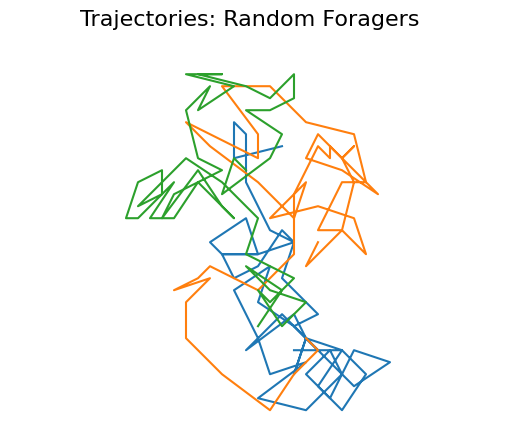

In [4]:
plot = ft.plot_trajectories(random_foragers_sim.foragersDF, "Random Foragers")
plot.show()

The foragers' movements can be visualized using the `animate_foragers` function.

In [6]:
ft.animate_foragers(
    random_foragers_sim, width=600, height=400, plot_rewards=True, point_size=6
)

## Derived quantities
Suppose we observed this movement data from agents out in the world, and have several hypotheses for what may be contributing to the agents' movement decisions. We'll calculate derived predictor scores, which have high weight at locations/times where that hypothesis predicts that birds would want to go. 

In practice, given the simulated data, we compute the values of the different derived quantities (predictors/scores) $f_k^{(i)}(x,y,t),\;k=1,\dots,N_{D}$ for every forager $i$ at every timestep $t$, giving the predicted expected future value for $i$ at every grid point $(x,y)$ and time step $t+1$.

At the inference stage, we shall fit the scores to a linear combination of predictors with unknown coefficients.


### Computation

The main function computing the predictors is `derive_predictors_and_scores` (see documentation by `help(ft.derive_predictors_and_scores)`)

In [7]:
help(ft.derive_predictors_and_scores)

Help on function derive_predictors_and_scores in module collab2.foraging.toolkit.derive:

derive_predictors_and_scores(foragers_object: collab2.foraging.toolkit.utils.dataObject, local_windows_kwargs: Dict[str, Any], predictor_kwargs: Dict[str, Dict[str, Any]], score_kwargs: Dict[str, Dict[str, Any]], dropna: Optional[bool] = True, add_scaled_values: Optional[bool] = False) -> pandas.core.frame.DataFrame
    A function that calculates a chosen set of predictors and scores for data by inferring their names from
    keys in `predictor_kwargs` & `score_kwargs`, and dynamically calling the corresponding functions.
    :param foragers_object: instance of dataObject class containing the trajectory data of foragers.
    :param local_window_kwargs: dictionary of keyword arguments for `generate_local_windows` function.
    :param predictor_kwargs: nested dictionary of keyword arguments for predictors to be computed.
            Keys of predictor_kwargs set the name of the predictor to be comput

The local windows are used to compute the predictors and the scores over. A local window is generated for each forager at every time step.

In [8]:
help(ft.local_windows.generate_local_windows)

Help on function generate_local_windows in module collab2.foraging.toolkit.local_windows:

generate_local_windows(foragers_object: collab2.foraging.toolkit.utils.dataObject) -> List[List[pandas.core.frame.DataFrame]]
    A wrapper function that calculates `local_windows` for a dataObject by calling `_generate_local_windows`
    with parameters inherited from the dataObject.
    :param foragers_object: dataObject containing foragers trajectory data
        Must have `local_windows_kwargs` as an attribute
    
    :return: Nested list of local_windows (DataFrames with "x","y" columns) grouped by forager index and time
    
    The list of keyword arguments:
        :param window_size: radius of local_windows. Default: 1.0
        :param sampling_fraction: fraction of grid points to sample. It may be advisable to subsample
            grid points for speed
        :param random_seed: random state for subsampling. Default: 0
        :param skip_incomplete_frames: Defaults to False. If True

Let's use sensible defaults:

In [9]:
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

The list of available predictors and scores can be obtained via the following:

In [10]:
available_predictors = ft.get_list_of_predictors()
available_scores = ft.get_list_of_scores()

print("Available predictors: ", available_predictors)
print("Available scores: ", available_scores)

Available predictors:  ['access', 'food', 'pairwiseCopying', 'proximity', 'vicsek']
Available scores:  ['nextStep']


In the example below, we'll use `proximity`, `food` and `access` predictors.

In [11]:
help(ft.generate_proximity_predictor)

Help on function generate_proximity_predictor in module collab2.foraging.toolkit.proximity:

generate_proximity_predictor(foragers_object: collab2.foraging.toolkit.utils.dataObject, predictor_name: str)
    Generates proximity-based predictors for a group of foragers by invoking the proximity predictor mechanism.
    
    This function retrieves the relevant parameters from the provided `foragers_object` and uses them to compute
    the proximity predictor values. It relies on the `_proximity_predictor` function to handle the detailed
    calculations and updates.
    
    :param foragers_object: A data object containing information about the foragers, including their positions,
                            trajectories, and local windows. Such objects can be generated using `object_from_data`.
    :param predictor_name: The name of the proximity predictor to be generated, used to fetch relevant parameters
                           from `foragers_object.predictor_kwargs` and to store t

Similarly one can look up the parameters for the other predictors.

In [12]:
help(ft.generate_access_predictor)

Help on function generate_access_predictor in module collab2.foraging.toolkit.access:

generate_access_predictor(foragers_object: collab2.foraging.toolkit.utils.dataObject, predictor_name: str)
    Generates access-based predictors for a group of foragers. Access is defined as the ability of a forager
    to reach a specific location in space. For a homogeneous environment, the value of the predictor is
    inversely proportional to the distance between the forager and the target location. The decay function
    can be customized.
    
    Arguments:
    :param foragers_object: A data object containing information about the foragers, including their positions,
                            trajectories, and local windows. Such objects can be generated using `object_from_data`.
    :param predictor_name: The name of the access predictor to be generated, used to fetch relevant parameters
                           from `foragers_object.predictor_kwargs` and to store the computed values.
  

In [13]:
help(ft.generate_food_predictor)

Help on function generate_food_predictor in module collab2.foraging.toolkit.food:

generate_food_predictor(foragers_object: collab2.foraging.toolkit.utils.dataObject, predictor_name: str)
    Generates food-based predictors for a group of foragers. Food is given
    by the presence of rewards in the environment. The value of the predictor
    is proportional to the rewards in the vicinity of the forager. The decay
    function can be customized.
    
    Arguments:
    :param foragers_object: A data object containing information about the foragers, including their positions,
                            trajectories, and local windows. Such objects can be generated using `object_from_data`.
    :param predictor_name: The name of the food predictor to be generated, used to fetch relevant parameters
                           from `foragers_object.predictor_kwargs` and to store the computed values.
    
    :return: A list of lists of pandas DataFrames where each DataFrame has been update

The score computation is completely analogous: it is done over the local windows, and computed for each forager at every time step.

In [14]:
help(ft.generate_nextStep_score)

Help on function generate_nextStep_score in module collab2.foraging.toolkit.next_step_score:

generate_nextStep_score(foragers_object: collab2.foraging.toolkit.utils.dataObject, score_name: str)
    A wrapper function that computes `next_step_score` only taking `foragers_object` as argument,
    and calling `_generate_next_step_score` under the hood.
    
    The next step score computes a score for how far grid points are from the next position of a forager.
    If the next position of the forager is unavailable, nan values are assigned to the scores.
    
    The formula for the score is:
        next_step_score(i,t,x,y) = 1 - (d_scaled) ** n
        where d_scaled = (d - min(d)) / (max(d) - min(d))
    
    Here d is the vector of distances of grid points in the local window of forager i at time t
    from the position of forager i at time t+1.
    
    :param foragers_object: dataObject containing positional data, local_windows, score_kwargs
    :param score_name : name of column t

In [15]:
predictor_kwargs = {
    "proximity": {
        "interaction_length": random_foragers_sim.grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
    "food": {
        "decay_factor": 0.5,
    },
    "access": {
        "decay_factor": 0.2,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF_random = ft.derive_predictors_and_scores(
    random_foragers_sim,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

display(derivedDF_random.head())

2024-09-27 12:16:01,283 - proximity completed in 0.66 seconds.
2024-09-27 12:16:01,762 - food completed in 0.48 seconds.
2024-09-27 12:16:01,941 - access completed in 0.18 seconds.
2024-09-27 12:16:02,144 - nextStep_linear completed in 0.20 seconds.
2024-09-27 12:16:02,274 - nextStep_sublinear completed in 0.13 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 903/44578 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



x   y  distance_to_forager  time  forager  proximity      food    access  \
0  10  23            10.000000     0        0   0.047853  0.307712  0.135335   
1  11  19             9.848858     0        0   0.123592  0.276273  0.139489   
2  11  20             9.486833     0        0   0.157399  0.284462  0.149963   
3  11  21             9.219544     0        0   0.171165  0.287977  0.158198   
4  11  22             9.055385     0        0   0.157952  0.303529  0.163478   

   distance_to_next_step  nextStep_linear  nextStep_sublinear  \
0              14.000000         0.000000            0.000000   
1              13.601471         0.028466            0.014336   
2              13.341664         0.047024            0.023795   
3              13.152946         0.060504            0.030724   
4              13.038405         0.068685            0.034954   

   proximity_scaled  food_scaled  access_scaled  nextStep_linear_scaled  \
0          0.523927     0.307678       0.000000                0.000000   
1          0.561796     0.276238       0.004804                0.028466   
2          0.578699     0.284427       0.016917                0.047024   
3          0.585583     0.287943       0.026441                0.060504   
4          0.578976     0.303495       0.032548                0.068685   

   nextStep_sublinear_scaled  
0                   0.000000  
1                   0.014336  
2                   0.023795  
3                   0.030724  
4                   0.034954

### Visualization

The spatial distributions of the values for each $f_k$ can be conveniently visualized using `plot_predictor` helper function. The parameters are mostly self-explanatory.

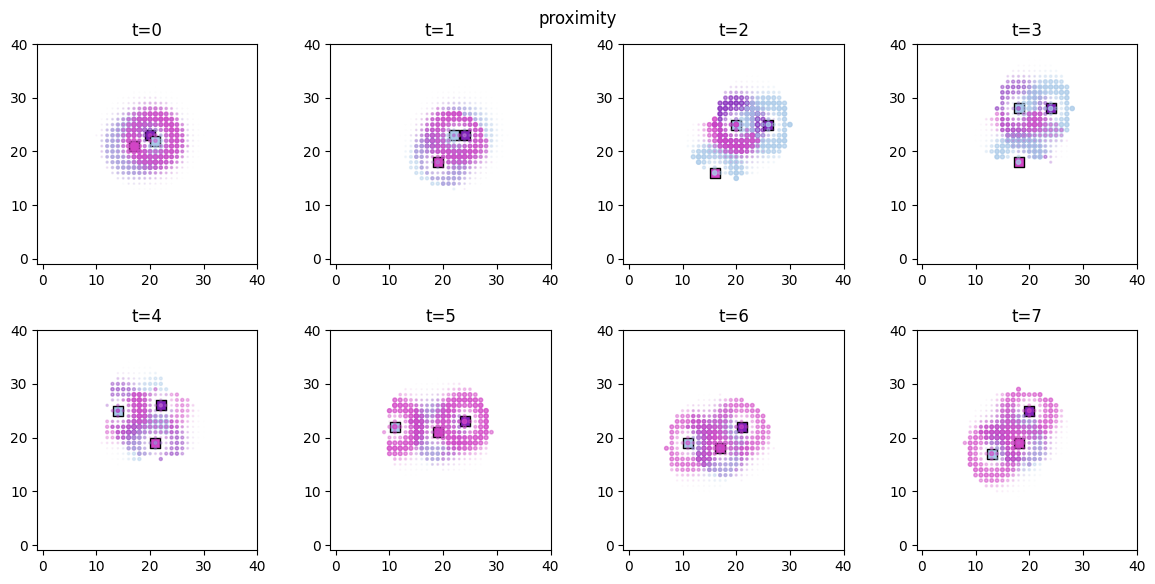

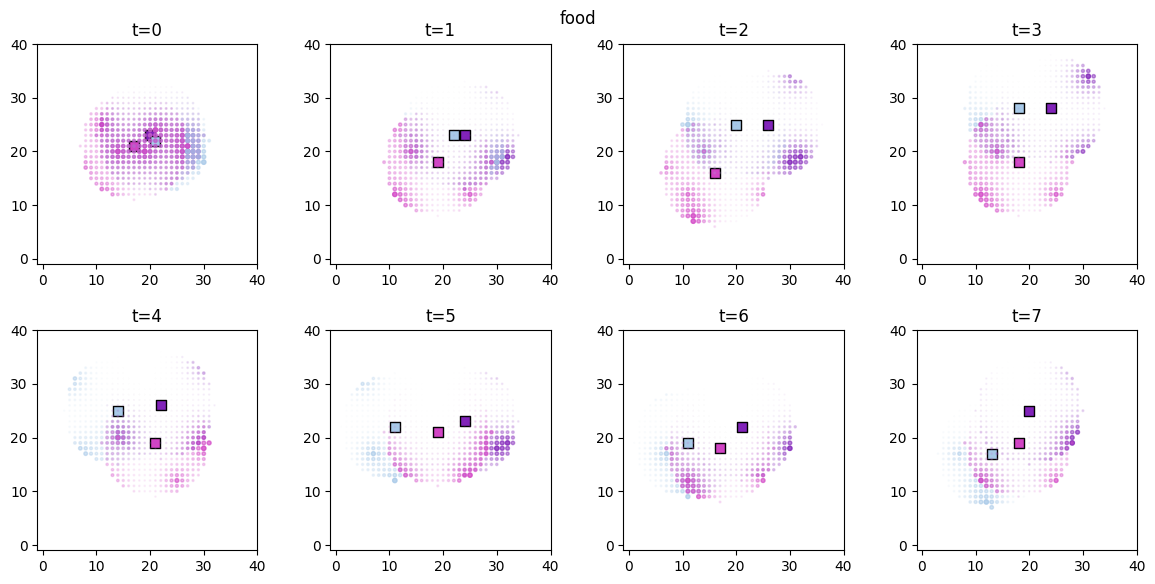

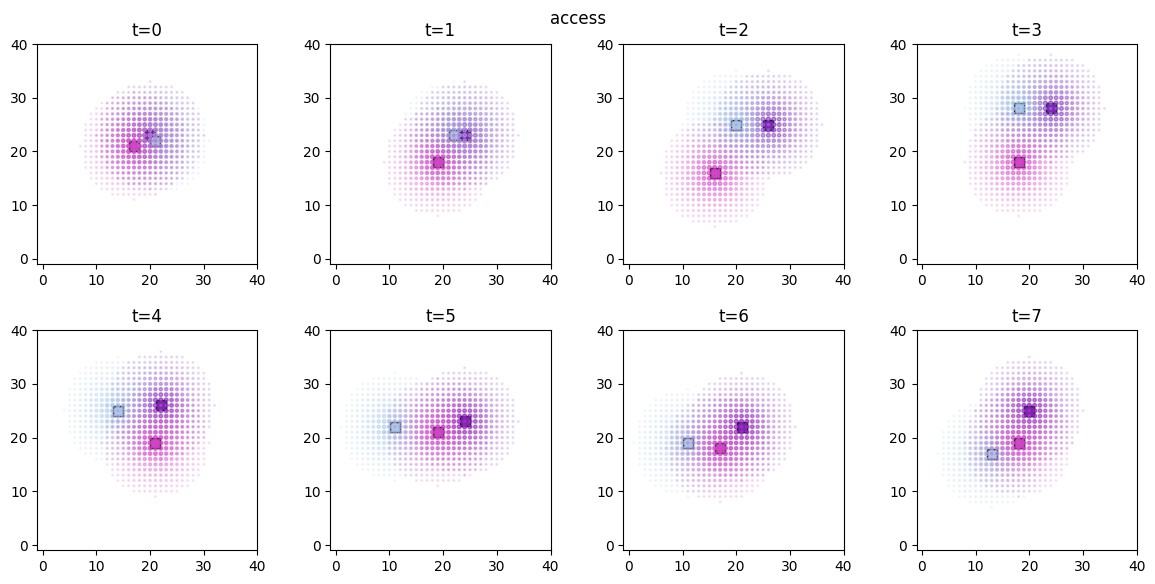

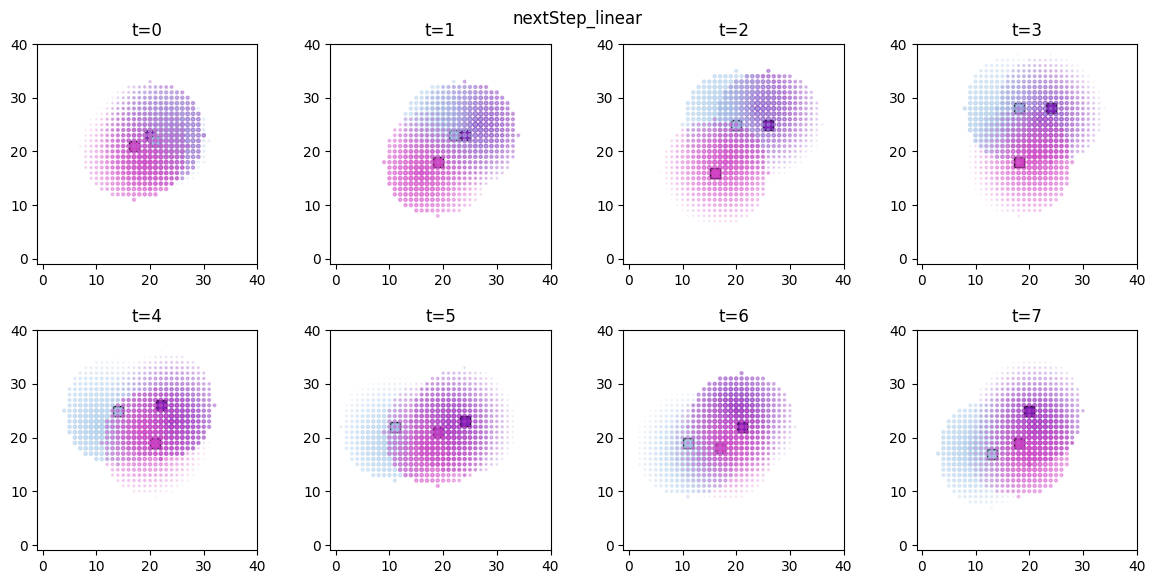

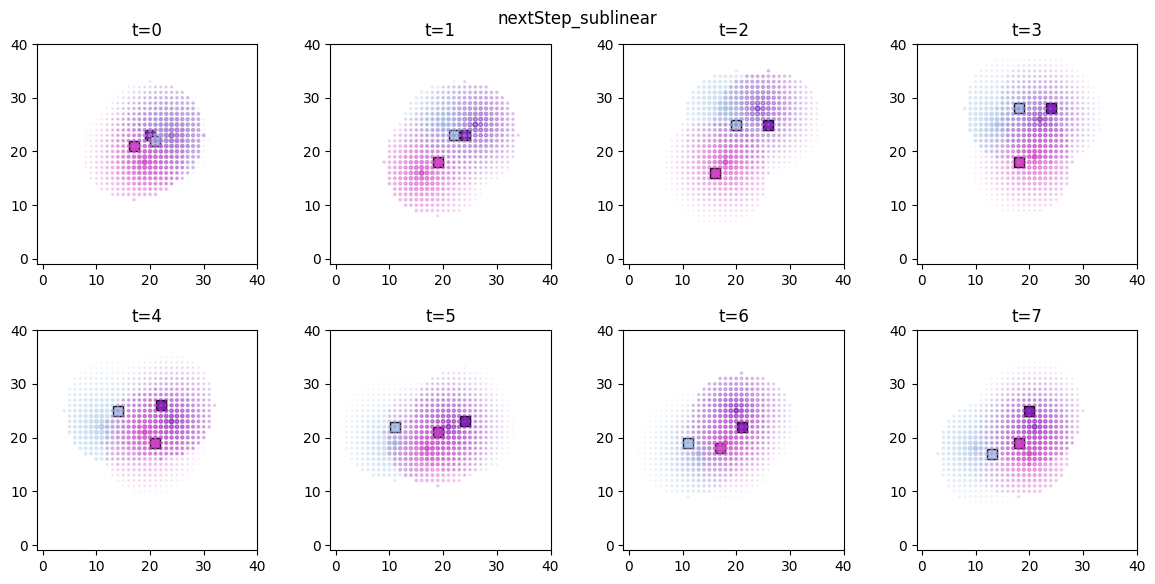

In [16]:
for derived_quantity_name in random_foragers_sim.derived_quantities.keys():
    ft.plot_predictor(
        random_foragers_sim.foragers,
        random_foragers_sim.derived_quantities[derived_quantity_name],
        predictor_name=derived_quantity_name,
        time=range(min(8, num_frames)),
        grid_size=40,
        size_multiplier=10,
        random_state=99,
        forager_position_indices=[0, 1, 2],
        forager_predictor_indices=[0, 1, 2],
    )
    plt.suptitle(derived_quantity_name)
    plt.show()

The time evolution of the derived values can be conveniently animated.

2024-09-27 12:16:26,021 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


50


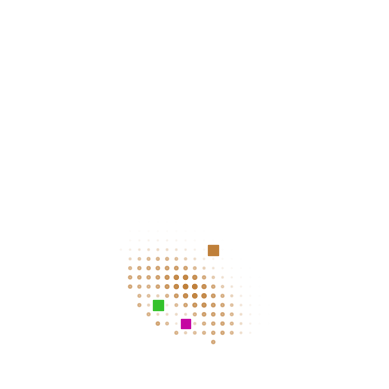

In [17]:
ani = ft.animate_predictors(
    random_foragers_sim.foragersDF,
    random_foragers_sim.derived_quantities["proximity"],
    predictor_name="proximity",
    forager_position_indices=[0, 1, 2],
    forager_predictor_indices=[1],
    grid_size=40,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

2024-09-27 12:16:50,156 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


50


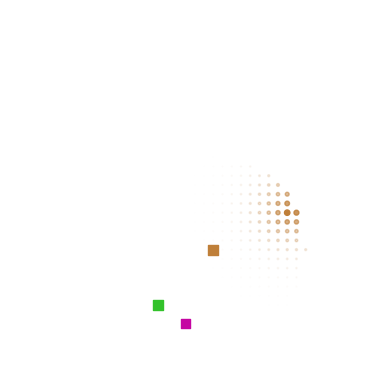

In [18]:
ani = ft.animate_predictors(
    random_foragers_sim.foragersDF,
    random_foragers_sim.derived_quantities["food"],
    predictor_name="food",
    forager_position_indices=[0, 1, 2],
    forager_predictor_indices=[1],
    grid_size=40,
    random_state=10,
    size_multiplier=15,
)
HTML(ani.to_jshtml())

## Inference

Now we fit the next step distribution of the expected value as a linear combination of the predictors:

$$
\operatorname{nextStep}^i(x, y, t) \sim \operatorname{Normal}\left(V^i(x, y, t), \sigma(x, y, t)\right)
$$
where
$$
V^i(x, y, t) = \sum_{k=1}^{N_p} c_k f^{(i)}_k(x,y,t).
$$

The actual score values $\widetilde{V^i}$ and the predictor values $f_k^{(i)}$ are precisely the derived quantities computed previously.

We start by preparing the training data as tensor dictionaries. All the data is flattened to 1D.

In [19]:
predictors = ["proximity_scaled", "food_scaled", "access_scaled"]
outcome_vars = ["nextStep_sublinear"]

predictor_tensors_random, outcome_tensor_random = ft.prep_data_for_inference(
    random_foragers_sim, predictors, outcome_vars
)

predictor_tensors_random, outcome_tensor_random

({'proximity_scaled': tensor([0.5239, 0.5618, 0.5787,  ..., 0.5725, 0.6671, 0.5055]),
  'food_scaled': tensor([0.3077, 0.2762, 0.2844,  ..., 0.5081, 0.7455, 0.1851]),
  'access_scaled': tensor([0.0000, 0.0048, 0.0169,  ..., 0.0169, 0.0048, 0.0000])},
 {'nextStep_sublinear': tensor([0.0000, 0.0143, 0.0238,  ..., 0.1496, 0.1343, 0.1088])})

In [20]:
# plot outcome vs predictors
ft.visualise_forager_predictors(
    predictors=[
        predictor_tensors_random["proximity_scaled"],
        predictor_tensors_random["food_scaled"],
        predictor_tensors_random["access_scaled"],
    ],
    predictor_names=["proximity_scaled", "food_scaled", "access_scaled"],
    outcome_name="nextStep_sublinear",
    outcome=outcome_tensor_random["nextStep_sublinear"],
    sampling_rate=0.5,
)

Now we create the Pyro model.

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning:

Can't initialize NVML



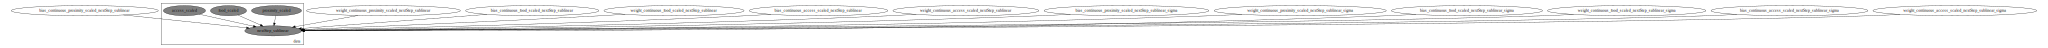

In [21]:
model_sigmavar_random = ft.HeteroskedasticLinear(
    predictor_tensors_random, outcome_tensor_random
)
pyro.render_model(
    model_sigmavar_random,
    model_args=(predictor_tensors_random, outcome_tensor_random),
    # render_deterministic=True, # this requires Pyro>1.9
)

The `get_samples` function runs the Stochastic Variational Inference algorithm in `Pyro` and returns posterior samples.

2024-09-27 12:18:10,184 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 161231.7812
[iteration 0050] loss: 145141.3281
[iteration 0100] loss: 105649.7188
[iteration 0150] loss: 105150.4922
[iteration 0200] loss: 107383.8984
[iteration 0250] loss: 105131.8672
[iteration 0300] loss: 102684.9062
[iteration 0350] loss: 102890.3828
[iteration 0400] loss: 102519.6484
[iteration 0450] loss: 103171.0781
[iteration 0500] loss: 103400.4766
[iteration 0550] loss: 102938.7734
[iteration 0600] loss: 103334.5391
[iteration 0650] loss: 102614.4922
[iteration 0700] loss: 103112.0938
[iteration 0750] loss: 102616.4609
[iteration 0800] loss: 102597.7891
[iteration 0850] loss: 102454.9141
[iteration 0900] loss: 102846.3594
[iteration 0950] loss: 102860.4688
[iteration 1000] loss: 102514.9453
[iteration 1050] loss: 102504.3047
[iteration 1100] loss: 102479.8125
[iteration 1150] loss: 102439.6016
[iteration 1200] loss: 102974.0547
[iteration 1250] loss: 102603.4609
[iteration 1300] loss: 102483.7266
[iteration 1350] loss: 102636.7266
[iteration 1400] los

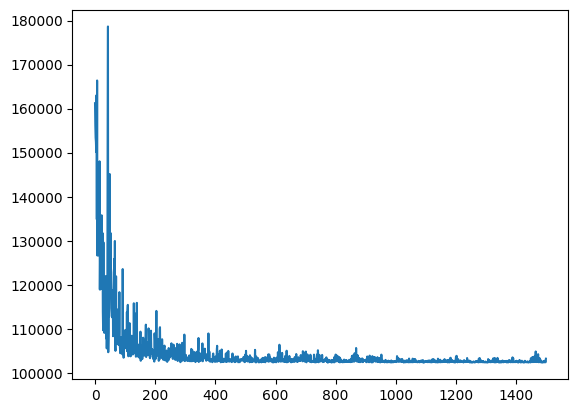

2024-09-27 12:18:46,808 - SVI inference completed in 36.62 seconds.


dict_keys(['bias_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_proximity_scaled_nextStep_sublinear', 'bias_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'bias_continuous_access_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear', 'bias_continuous_proximity_scaled_nextStep_sublinear_sigma', 'weight_continuous_proximity_scaled_nextStep_sublinear_sigma', 'bias_continuous_food_scaled_nextStep_sublinear_sigma', 'weight_continuous_food_scaled_nextStep_sublinear_sigma', 'bias_continuous_access_scaled_nextStep_sublinear_sigma', 'weight_continuous_access_scaled_nextStep_sublinear_sigma', 'proximity_scaled', 'food_scaled', 'access_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_scaled_nextStep_s

In [22]:
results_random = ft.get_samples(
    model=model_sigmavar_random,
    predictors=predictor_tensors_random,
    outcome=outcome_tensor_random,
    num_svi_iters=1500,
    num_samples=1000,
)

We can now visualize the posterior distributions of the parameters $
\{c_k\}$.

In [23]:
selected_sites = [
    key
    for key in results_random["samples"].keys()
    if key.startswith("weight") and not key.endswith("sigma")
]
selected_samples = {key: results_random["samples"][key] for key in selected_sites}

ft.plot_coefs(
    selected_samples, "Random foragers", nbins=120, ann_start_y=160, ann_break_y=50
)

As expected, the only nonzero coefficient is `access`. The access prefictor is indeed independent from the other foragers or the food distribution, and depends solely on the distance between the forager and the target location. In our case:
$$
f_{access}^{(i)}(x,y,t) = \exp(-1/5*\operatorname{dist}(forager_i(t), (x,y))).
$$

Finally we are able to compare the resulting predictive distribution with the observed data. 

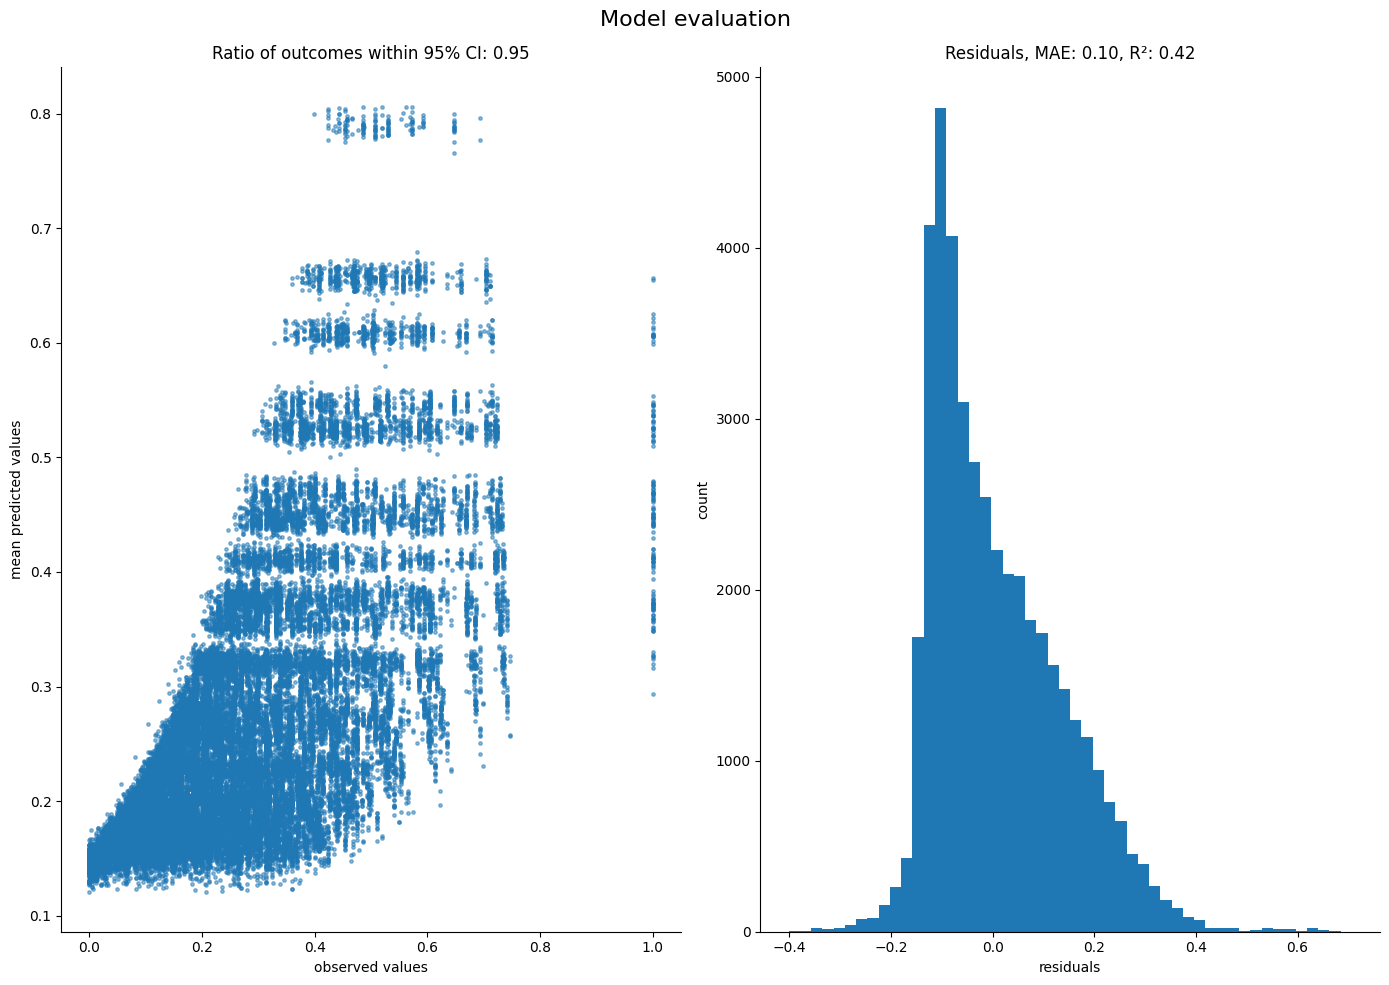

In [24]:
ft.evaluate_performance(
    model=model_sigmavar_random,
    guide=results_random["guide"],
    predictors=predictor_tensors_random,
    outcome=outcome_tensor_random,
    num_samples=1000,
)